# Выбор локации для скважины

Добывающей компании нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль, а также проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

### Условия задачи
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Загрузка и подготовка данных

Для начала импортируем все необходимые библиотеки и методы.

In [1]:
import pandas as pd

from numpy.random import RandomState

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from matplotlib import pyplot as plt

Зафиксируем в константе случайное состояние, которое будем использовать в проекте.

In [2]:
RANDOM_STATE = 322

Загрузим геоданные в переменные `data1`, `data2` и `data3`.

In [3]:
data1 = pd.read_csv('geo_data_0.csv')
data2 = pd.read_csv('geo_data_1.csv')
data3 = pd.read_csv('geo_data_2.csv')

Проверим информацию о данных, наличие дубликатов и пропусков:

In [4]:
data1.info()
print()
data2.info()
print()
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Nul

In [5]:
print(data1.isna().sum(), '\n')
print(data2.isna().sum(), '\n')
print(data3.isna().sum(), '\n')

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64 

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64 

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64 



In [6]:
print(data1.duplicated().sum())
print(data2.duplicated().sum())
print(data3.duplicated().sum())

0
0
0


Данные в порядке, пропусков и дубликатов нет. Удалим из всех фреймов текстовый столбец `'id'`, он нам не понадобится. 

In [7]:
data1 = data1.drop('id', axis=1)
data2 = data2.drop('id', axis=1)
data3 = data3.drop('id', axis=1)

In [8]:
data1.head()

,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647


In [9]:
data2.head()

,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305
3,-13.081196,-11.506057,4.999415,137.945408
4,12.702195,-8.147433,5.004363,134.766305


In [10]:
data3.head()

,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697
2,0.194587,0.289035,-5.586433,62.871910
3,2.236060,-0.553760,0.930038,114.572842
4,-0.515993,1.716266,5.899011,149.600746


Дополнительно посмотрим на распределение целевого признака в каждом из регионов:

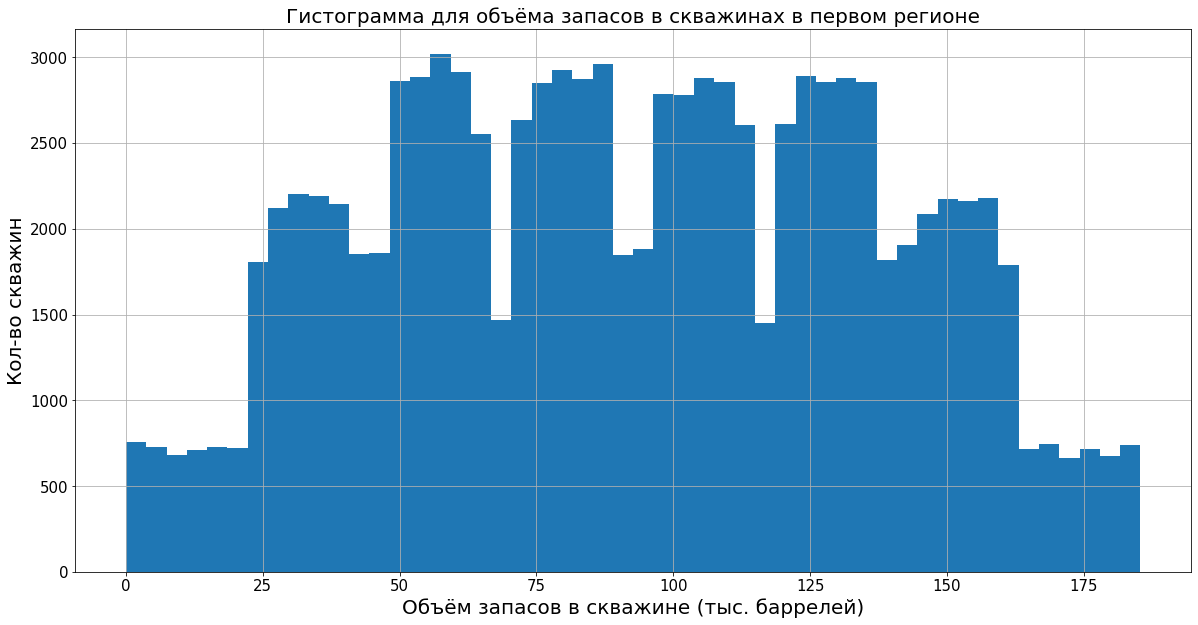

In [11]:
data1['product'].hist(bins=50, figsize=(20, 10)).tick_params(labelsize=15)
plt.title('Гистограмма для объёма запасов в скважинах в первом регионе', fontsize=20)
plt.ylabel('Кол-во скважин', fontsize=20)
plt.xlabel('Объём запасов в скважине (тыс. баррелей)', fontsize=20);

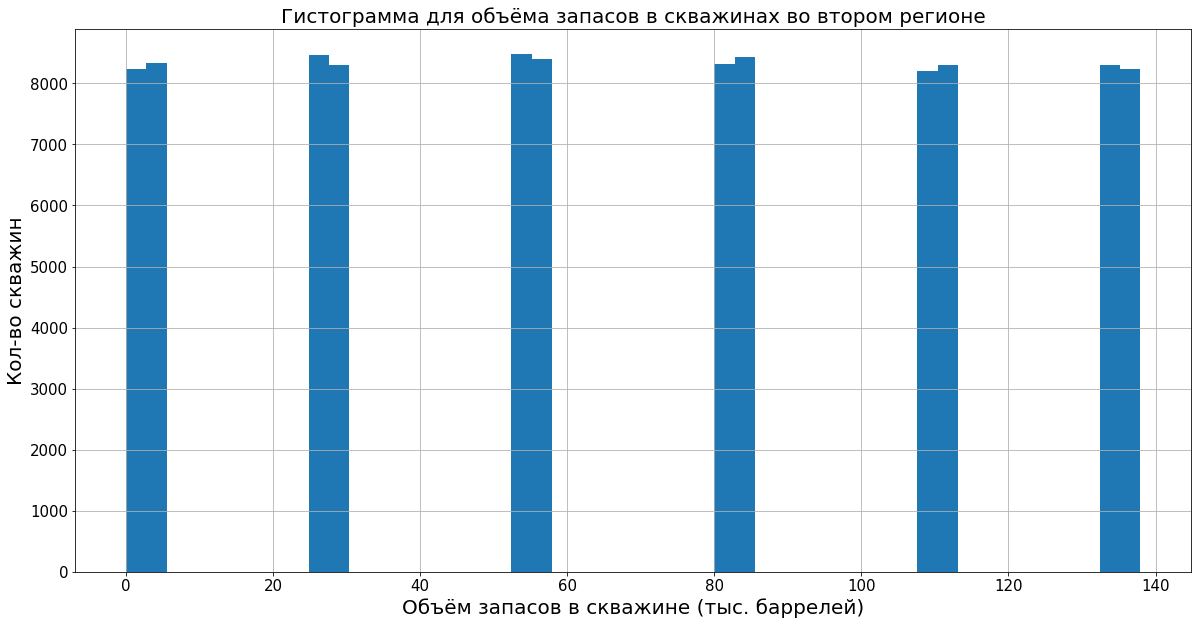

In [12]:
data2['product'].hist(bins=50, figsize=(20, 10)).tick_params(labelsize=15)
plt.title('Гистограмма для объёма запасов в скважинах во втором регионе', fontsize=20)
plt.ylabel('Кол-во скважин', fontsize=20)
plt.xlabel('Объём запасов в скважине (тыс. баррелей)', fontsize=20);

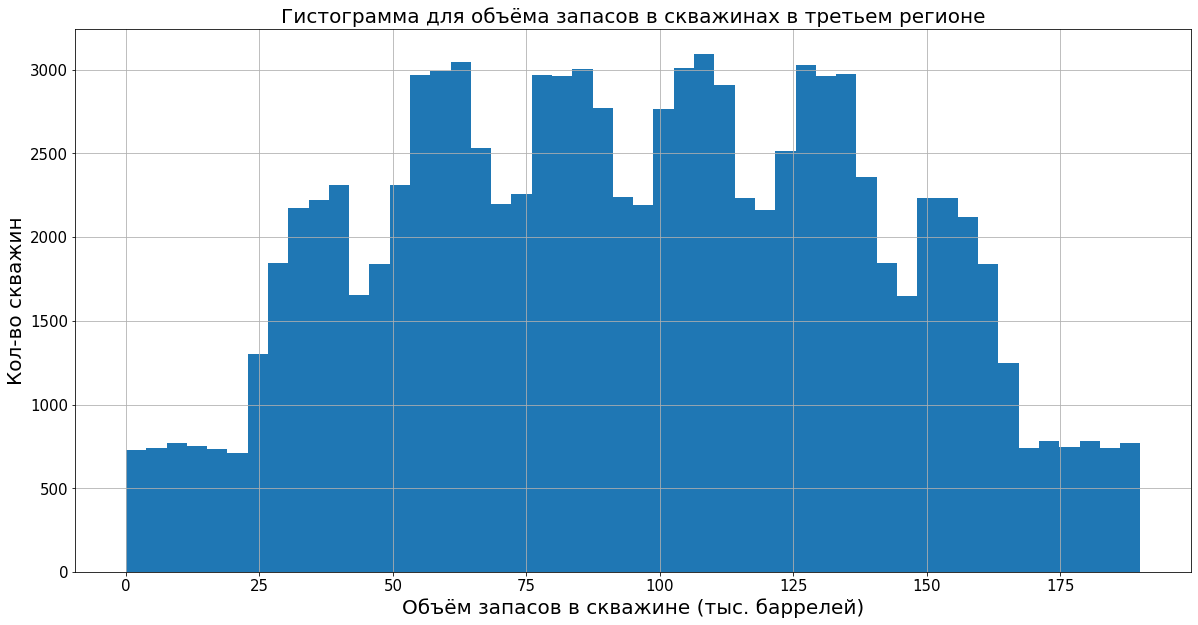

In [13]:
data3['product'].hist(bins=50, figsize=(20, 10)).tick_params(labelsize=15)
plt.title('Гистограмма для объёма запасов в скважинах в третьем регионе', fontsize=20)
plt.ylabel('Кол-во скважин', fontsize=20)
plt.xlabel('Объём запасов в скважине (тыс. баррелей)', fontsize=20);

Во втором регионе (`geo_data_1.csv`) видно необычное распределение целевого признака. Посмотрим на уникальные значения целевого признака в этом регионе:

In [14]:
data2['product'].unique()

array([  3.17910258,  26.95326103, 134.76630516, 137.94540774,
        84.03888568, 110.99214671,  53.90652206,   0.        ,
       107.81304413,  57.08562465,  30.13236361,  80.85978309])

Во втором регионе целевой признак можно назвать дискретным, он принимает всего 12 различных значений. К тому же, эти значения распределены достаточно равномерно. В остальных регионах целевой признак непрерывный.

## Обучение и проверка модели

### Разделение данных на обучающую и валидационную выборки

Разделим данные на обучающую и валидационную выборки в каждом регионе. Целевым признаком для моделей является столбец `'product'`.

In [15]:
features1 = data1.drop('product', axis=1)
target1 = data1['product']

features2 = data2.drop('product', axis=1)
target2 = data2['product']

features3 = data3.drop('product', axis=1)
target3 = data3['product']

In [16]:
x1_train, x1_valid, y1_train, y1_valid = train_test_split(
    features1, target1, random_state=RANDOM_STATE)

x2_train, x2_valid, y2_train, y2_valid = train_test_split(
    features2, target2, random_state=RANDOM_STATE)

x3_train, x3_valid, y3_train, y3_valid = train_test_split(
    features3, target3, random_state=RANDOM_STATE)

### Обучение и получение предсказаний моделей по каждому из регионов

Для каждого региона создадим и обучим модель на тренировочных данных. Предсказания моделей запишем в переменные `'predictions1'`, `'predictions2'` и `'predictions3'`.

#### Регион 1

In [17]:
model1 = LinearRegression()
model1.fit(x1_train, y1_train)
predictions1 = pd.Series(model1.predict(x1_valid))

#### Регион 2

In [18]:
model2 = LinearRegression()
model2.fit(x2_train, y2_train)
predictions2 = pd.Series(model2.predict(x2_valid))

#### Регион 3

In [19]:
model3 = LinearRegression()
model3.fit(x3_train, y3_train)
predictions3 = pd.Series(model3.predict(x3_valid))

### RMSE моделей и средний запас предсказанного сырья

Посчитаем среднее отклонение предсказаний от фактических данных для каждого из регионов:

In [20]:
print('RMSE модели в первом регионе:', 
      mean_squared_error(y1_valid, predictions1, squared=False))

print('RMSE модели во втором регионе:', 
      mean_squared_error(y2_valid, predictions2, squared=False))

print('RMSE модели в третьем регионе:', 
      mean_squared_error(y3_valid, predictions3, squared=False))

RMSE модели в первом регионе: 37.71664266580217
RMSE модели во втором регионе: 0.8916722417789359
RMSE модели в третьем регионе: 40.13509716973861


Во втором регионе отклонение крайне маленькое, модель предсказывает значения достаточно точно.

Посчитаем среднее значение предсказанного сырья для каждого из регионов:

In [21]:
print('Средний запас предсказанного сырья в первом регионе:',
      predictions1.mean())

print('Средний запас предсказанного сырья модели во втором регионе:',
      predictions2.mean())

print('Средний запас предсказанного сырья модели в третьем регионе:', 
      predictions3.mean())

Средний запас предсказанного сырья в первом регионе: 92.60918187949363
Средний запас предсказанного сырья модели во втором регионе: 68.66976858021387
Средний запас предсказанного сырья модели в третьем регионе: 95.07765644364136


Во втором регионе средний предсказанный запас меньше всего, однако, этим данным мы можем доверять в большей степени, чем в двух других регионах.

## Подготовка к расчёту прибыли

### Сохранение значений в константы

Сохраним ключевые значения для будущих расчётов в константы:

In [22]:
POINTS_CHEKED = 500
BEST_POINTS = 200
BUDGET = 10_000_000_000
UNIT_REVENUE = 450_000

### Подсчёт объёма сырья для безубыточной разработки

Подсчитаем средний запас необходимого сырья в одной скважине. Так как мы планируем бурить 200 скважин, чтобы подсчитать затраты на одну скважину, нужно поделить весь бюджет на кол-во скважин. Полученное значение нужно поделить на стоимость тысячи баррелей нефти (т.к. в таблице указан объём в тыс. баррелей). Так мы получим средний запас сырья в одной скважине, который нужен для окупаемости проекта.

In [23]:
required_amount = BUDGET / BEST_POINTS / UNIT_REVENUE
required_amount

111.11111111111111

Как мы видим, средний необходимый запас больше среднего значения по каждому из регионов. Как раз поэтому мы будем выбирать 200 лучших скважин из 500 изучаемых, а также использовать Bootstrap для оценки рисков убытка в каждом из регионов.

### Функция расчёта прибыли

Напишем функцию для расчёта прибыли. Функция будет принимать в себя данные о 500 выбранных точках, а также все фактические данные о них. В функции мы будем выбирать 200 лучших точек по предсказаниям модели, а потом сопоставлять их с 200 точками из реальных данных. Функция будет возвращать подсчёт прибыли при каждом из различных вариантов выбора 500 точек для исследования (1000 вариантов будет перебираться в цикле в функции `bootstrap()`).

Прибыль считается по формуле [суммарный объём нефти * цена за единицу нефти - потраченный бюджет].

In [24]:
def profit(predictions, target):
    best_200_predictions = predictions.sort_values(ascending=False)[:BEST_POINTS]
    best_200_target = target[best_200_predictions.index]
    product = best_200_target.sum()
    
    return product * UNIT_REVENUE - BUDGET

## Расчёт прибыли и рисков 

### Применение Bootstrap

Применим технику Bootstrap для получения распределения возможной прибыли при разном выборе 500 исследуемых точек. Функция `bootstrap()` принимает в себя предсказания модели и фактические данные об объёме сырья, а возвращает распределение возможной прибыли.

In [25]:
state = RandomState(RANDOM_STATE)

def bootstrap(preds, target):
    profits = []
    target.reset_index(inplace=True, drop=True)
    
    for i in range(1000): 
        preds_subsample = preds.sample(POINTS_CHEKED, replace=True, random_state=state)  
        profits.append(profit(preds_subsample, target))
        
    return pd.Series(profits)

Запишем распределения прибыли в переменные для каждого из регионов:

In [26]:
profits1 = bootstrap(predictions1, y1_valid)
profits2 = bootstrap(predictions2, y2_valid)
profits3 = bootstrap(predictions3, y3_valid)

Построим гистограммы для возможной прибыли в каждом регионе:

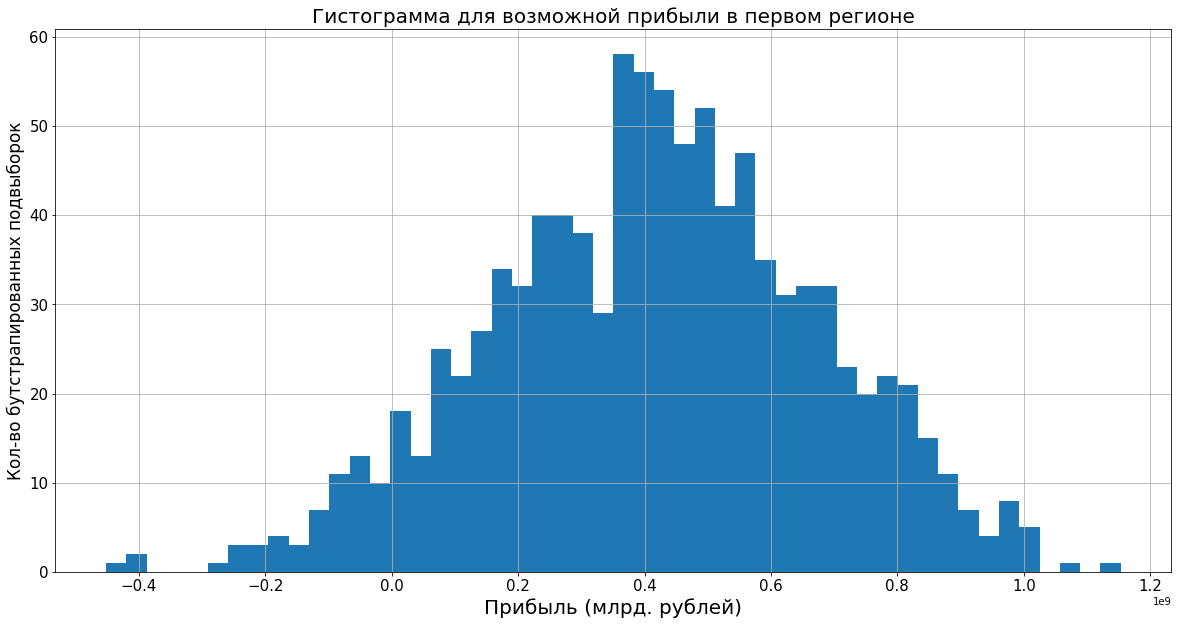

In [27]:
profits1.hist(bins=50, figsize=(20, 10)).tick_params(labelsize=15)
plt.title('Гистограмма для возможной прибыли в первом регионе', fontsize=20)
plt.ylabel('Кол-во бутстрапированных подвыборок', fontsize=17)
plt.xlabel('Прибыль (млрд. рублей)', fontsize=20);

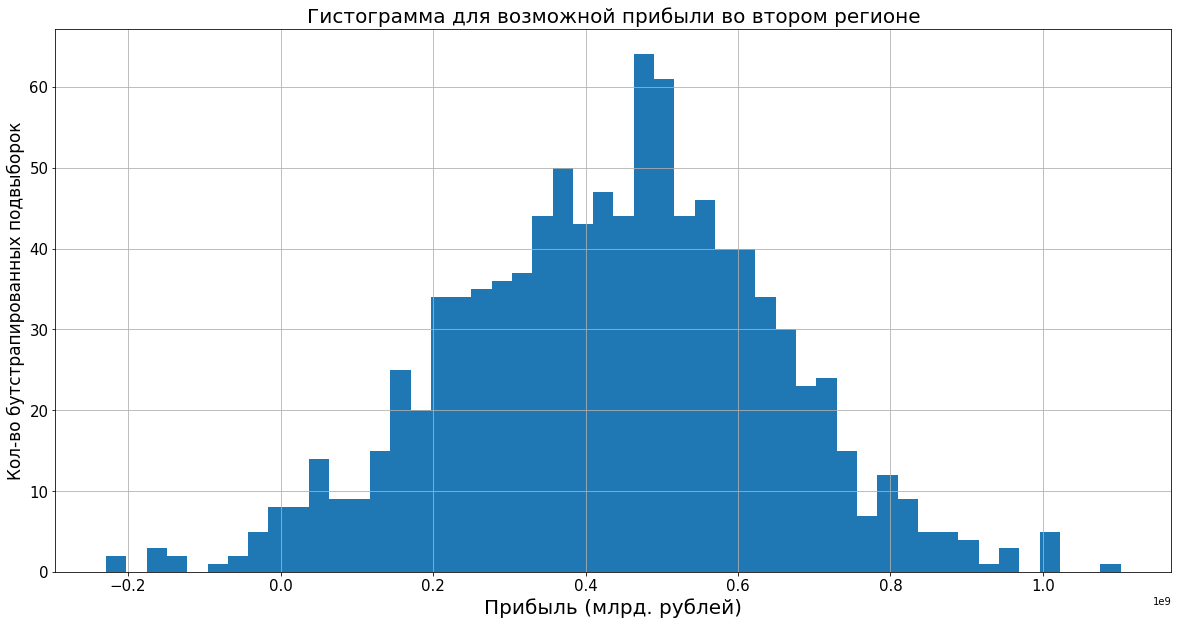

In [28]:
profits2.hist(bins=50, figsize=(20, 10)).tick_params(labelsize=15)
plt.title('Гистограмма для возможной прибыли во втором регионе', fontsize=20)
plt.ylabel('Кол-во бутстрапированных подвыборок', fontsize=17)
plt.xlabel('Прибыль (млрд. рублей)', fontsize=20);

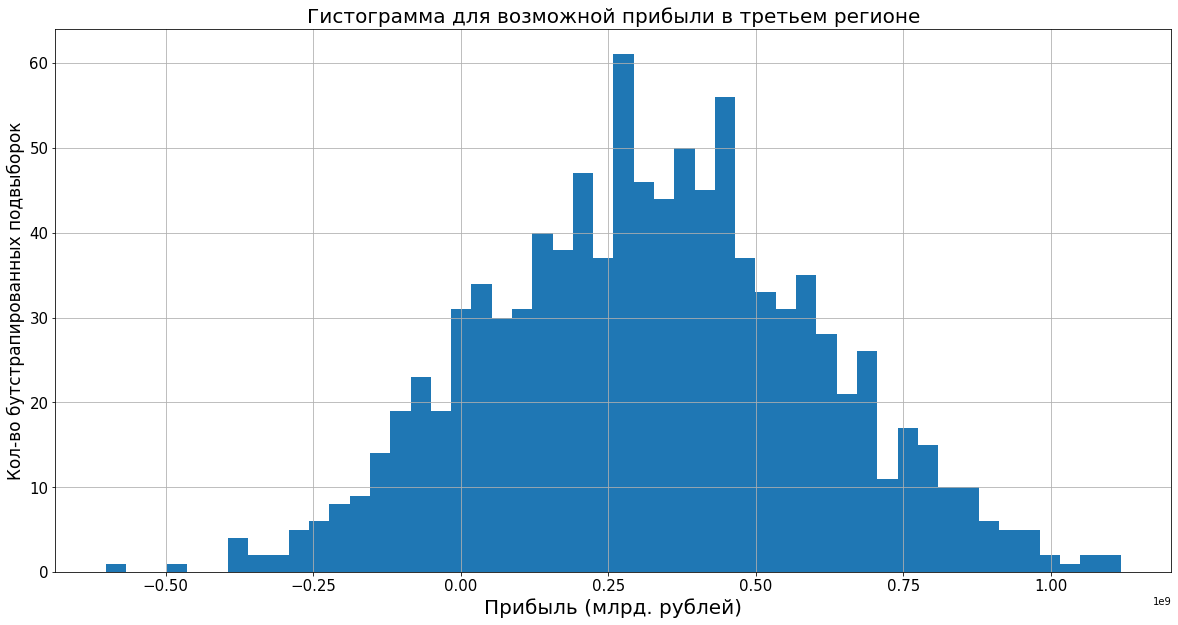

In [29]:
profits3.hist(bins=50, figsize=(20, 10)).tick_params(labelsize=15)
plt.title('Гистограмма для возможной прибыли в третьем регионе', fontsize=20)
plt.ylabel('Кол-во бутстрапированных подвыборок', fontsize=17)
plt.xlabel('Прибыль (млрд. рублей)', fontsize=20);

### Оценка рисков и среднее значение прибыли в регионе

Посмотрим на среднее значение прибыли в каждом из регионов:

In [30]:
print('1-ый регион:', profits1.mean())
print('2-ый регион:', profits2.mean())
print('3-ый регион:', profits3.mean())

1-ый регион: 415610707.9117105
2-ый регион: 435284356.4771178
3-ый регион: 324105965.9249046


Наивысшая прибыль получилась во втором регионе. Теперь нужно оценить риск убытка.

По условию заказчика, риск получить убыток (отрицательную прибыль) должен быть не более 2.5%. Таким образом, в распределениях прибыли значение 0.025 квантиля должно быть положительным. Если значение будет отрицательным, регион нам не подойдёт. Найдём значение 0.025 квантиля для каждого региона:

In [31]:
print('1-ый регион:', profits1.quantile(0.025))
print('2-ый регион:', profits2.quantile(0.025))
print('3-ый регион:', profits3.quantile(0.025))

1-ый регион: -92983523.98715076
2-ый регион: 24666248.955177832
3-ый регион: -200961642.5862318


Условию удовлетворяет только второй регион (`geo_data_1.csv`), в остальных регионах риск получить убытки больше 2.5%.

### Доверительные интервалы для прибыли

Построим доверительные 95% интервалы для прибыли в каждом из регионов. Эти интервалы располагаются между 0.025 квантилем и 0.975 квантилем, мы отсекаем по 2.5% значений с каждой стороны.

In [32]:
print(f"""95%-й доверительный интервал прибыли для первого региона:
от {profits1.quantile(0.025).round(1)} до {profits1.quantile(0.975).round(1)}\n""")
print(f"""95%-й доверительный интервал прибыли для второго региона:
от {profits2.quantile(0.025).round(1)} до {profits2.quantile(0.975).round(1)}\n""")
print(f"""95%-й доверительный интервал прибыли для третьего региона: 
от {profits3.quantile(0.025).round(1)} до {profits3.quantile(0.975).round(1)}\n""")

95%-й доверительный интервал прибыли для первого региона:
от -92983524.0 до 899524055.8

95%-й доверительный интервал прибыли для второго региона:
от 24666249.0 до 826725322.4

95%-й доверительный интервал прибыли для третьего региона: 
от -200961642.6 до 873714120.0



Теперь мы можем увидеть в каком промежутке будет находиться наша прибыль с вероятностью 95%. Хотя верхняя граница первого региона находится выше, чем у второго, в первом регионе выше вероятность убытков, поэтому он нам не подходит.

Посмотрим какие риски убытков для каждого из регионов:

In [33]:
print('Риск убытков в первом регионе: {:.2%} '.format((profits1 < 0).mean()))
print('Риск убытков во втором регионе: {:.2%} '.format((profits2 < 0).mean()))
print('Риск убытков в третьем регионе: {:.2%} '.format((profits3 < 0).mean()))

Риск убытков в первом регионе: 5.80% 
Риск убытков во втором регионе: 1.80% 
Риск убытков в третьем регионе: 13.10% 


По рискам видно, что у второго региона значительное преимущество. В первом и третьем регионах риск убытков выше в несколько раз, чем во втором. Поэтому, не сомневаясь выбираем второй регион.

## Вывод

Благодаря проведённому анализу геологических данных, мы смогли выбрать лучший регион для бурения новых скважин. Учитывая все условия заказчика нам подходит только регион №2 (`geo_data_1.csv`), в нём риски убытков минимальны. 